In [103]:
import pandas as pd 
import numpy as np 

# bayesian 
import pymc as pm 

# visualizations
import seaborn as sns 
import arviz as az
import graphviz

# pickle 
import pickle

In [165]:
test_df = pd.read_csv('data/2022_NYS_grad-rate.csv',dtype={'entity_cd':'string'})

In [159]:
district_dict = pd.read_pickle("district_lookup.pkl")

In [162]:
len(district_dict.keys())

413

In [167]:
len(test_df.entity_name.unique())

1240

In [45]:
# starting small -- using the 2022 combined grad rate dataset 

data = pd.read_csv('data/2022_NYS_grad-rate.csv',dtype={'entity_cd':'string'})
data

,entity_cd,entity_name,year,subgroup_name,grad_rate
0,010100010034,Albany High School,2022,Hispanic or Latino,73.7
1,010100010034,Albany High School,2022,White,86.9
2,010100010034,Albany High School,2022,Multiracial,77.4
3,010100010034,Albany High School,2022,English Language Learner,70.4
4,010100010034,Albany High School,2022,Economically Disadvantaged,75.5
...,...,...,...,...,...
4675,671501040002,Warsaw Senior High School,2022,Economically Disadvantaged,88.1
4676,680601060001,Penn Yan Academy,2022,White,91.1
4677,680601060001,Penn Yan Academy,2022,Economically Disadvantaged,88.6
4678,680801040001,Dundee Junior-Senior High School,2022,White,78.6


In [46]:
county_lookup = pd.read_pickle('county_lookup.pkl')

In [47]:
data['county_code'] = data.entity_cd.str[:2]
data.county_code = data.county_code.map(county_lookup)
data = data.rename(columns={'county_code':'county','subgroup_name':'subgroup'})
data = data[['county', 'grad_rate', 'subgroup']]

In [48]:
subgroup_dict = {'Hispanic or Latino':0,'White':1,'Multiracial':2,
                'English Language Learner':3,'Economically Disadvantaged':4,'Students with Disabilities':5,
                'Asian or Native Hawaiian/Other Pacific Islander':6,'Black or African American':7,
                 'American Indian or Alaska Native':8,}

In [49]:
data['subgroup_norm'] = data.subgroup
data['subgroup_norm'] = data.subgroup_norm.map(subgroup_dict)

,county,grad_rate,subgroup,subgroup_norm
0,Albany,73.7,Hispanic or Latino,0
1,Albany,86.9,White,1
2,Albany,77.4,Multiracial,2
3,Albany,70.4,English Language Learner,3
4,Albany,75.5,Economically Disadvantaged,4
...,...,...,...,...
4675,Wyoming,88.1,Economically Disadvantaged,4
4676,Yates,91.1,White,1
4677,Yates,88.6,Economically Disadvantaged,4
4678,Yates,78.6,White,1


In [50]:
data.subgroup_norm.value_counts()

subgroup_norm
4    1166
1     782
5     748
0     742
7     631
6     272
3     270
2      54
8      15
Name: count, dtype: int64

In [38]:
data.subgroup.unique().tolist()

['Hispanic or Latino',
 'White',
 'Multiracial',
 'English Language Learner',
 'Economically Disadvantaged',
 'Students with Disabilities',
 'Asian or Native Hawaiian/Other Pacific Islander',
 'Black or African American',
 'American Indian or Alaska Native']

### Unpooled/Non-Hierarchical Model 

To start, we'll start off with a non-hierarchical model for each county `n=61`. For each county, our goal is to understand whether the `county` has a different relationship in regard to `graduation_rate` which in our case, is a single paramater. [Following the radon study example on PyMc3 documentation:](https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/generalized_linear_models/GLM-hierarchical.html)

**Note:** `a` and `b` are constants following a Normal distribution which represent our prior??; `e

In [17]:
county_idxs, counties = pd.factorize(data.county)
coords = {'county': counties,
         "obs_id": np.arange(len(county_idxs))}

In [195]:
with pm.Model(coords=coords) as unpooled_model: 
    county_idx = pm.ConstantData('county_idx', county_idxs, dims='obs_id')
    subgroup = pm.ConstantData('subgroup', data.subgroup_norm.values, dims='obs_id')
    
    a = pm.Normal("a", 0, sigma=100, dims='county')
    b = pm.Normal('b', 0, sigma=100, dims='county')
    
    # model error 
    # not really confident what this means and the distribution it follows 
    eps = pm.HalfCauchy('eps', 5)
    
    # model prediction of graduation rate
    # where it follows a standard regression y = mx+b 
    # not sure what this formula means?
    # that each county has a different set of coefficients ?
    grad_est = a[county_idx] + b[county_idx] * subgroup
    
    y = pm.Normal('y', grad_est, sigma=eps, observed=data.grad_rate,dims='obs_id')

In [194]:
y

y ~ Normal(f(a), sigma)

**Note:** Not sure what `trace` is providing us with -- possibly the results of MCMC?

In [55]:
with unpooled_model: 
    unpooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 72 seconds.


### Hierarchical Modeling 

The previous model takes a macro-level approach to understanding the relationship between county -> graduation rate. The hierarchical model, considers each county to have different means and stds. 

In [130]:
with pm.Model(coords=coords) as hierarchical_model: 
    county_idx = pm.ConstantData('county_idx', county_idxs, dims='obs_id')
    
    # not sure 
    mu_a = pm.Normal('mu_a', mu=0.0, sigma=1)
    sigma_a = pm.HalfNormal('sigma_a', 5.0)
    mu_b = pm.Normal('mu_b', mu=0.0, sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', 5.0)
    
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, dims='county')
    b = pm.Normal('b',mu=mu_b,sigma=sigma_b,dims='county')
    
    eps = pm.HalfCauchy('eps',5.0)
    
    grad_est = a[county_idx] + b[county_idxs] * data.subgroup_norm.values
    
    grad_like = pm.Normal(
        "grad_like", mu=grad_est, sigma=eps, observed=data.grad_rate, dims='obs_id')

In [131]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, eps]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 137 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


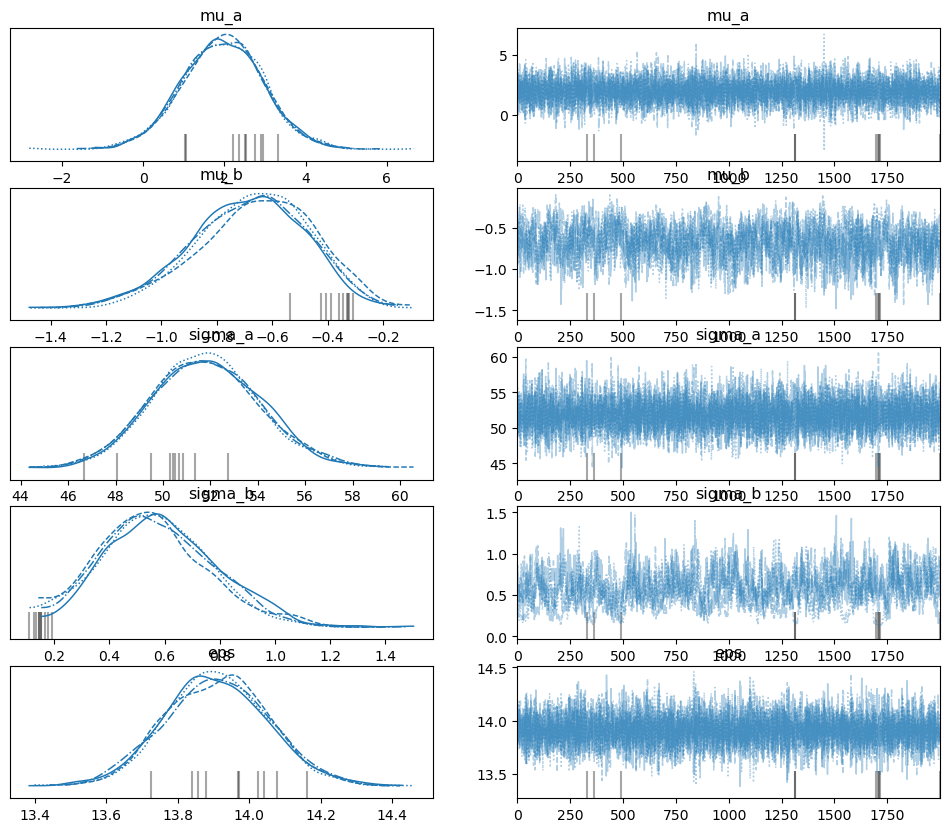

In [132]:
# not really sure what trace is ?
az.plot_trace(hierarchical_trace, var_names = ['mu_a', 'mu_b', 'sigma_a', 'sigma_b', 'eps']);

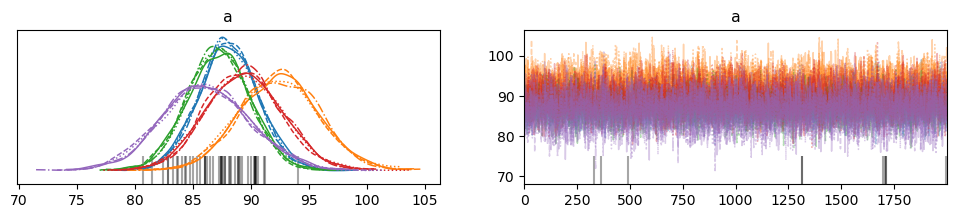

In [133]:
az.plot_trace(hierarchical_trace, var_names=['a'], coords={'county':counties[:5]});

In [157]:
# getting the maximum a posteriori (MAP) for hierarchical model 
map_estimate = pm.find_MAP(model=hierarchical_model)
map_estimate

{'mu_a': array(0.35697707),
 'sigma_a_log__': array(-18.73828677),
 'mu_b': array(1.34034805),
 'sigma_b_log__': array(-0.53715931),
 'a': array([0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707, 0.35697707, 0.35697707, 0.35697707, 0.35697707,
        0.35697707]),
 'b': array([1.04709486,

In [134]:
# i think this refers to the posterior predictive check 
# not sure how to evaluate + interpret 
with hierarchical_model:
    ppc = pm.sample_posterior_predictive(
        hierarchical_trace, var_names=['mu_a', 'mu_b', 'sigma_a', 'sigma_b', 'eps'], random_seed=1055)

Sampling: [eps, mu_a, mu_b, sigma_a, sigma_b]


C:\Users\Kevin\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (127) in plot_posterior, generating only 40 plots
  warnings.warn(


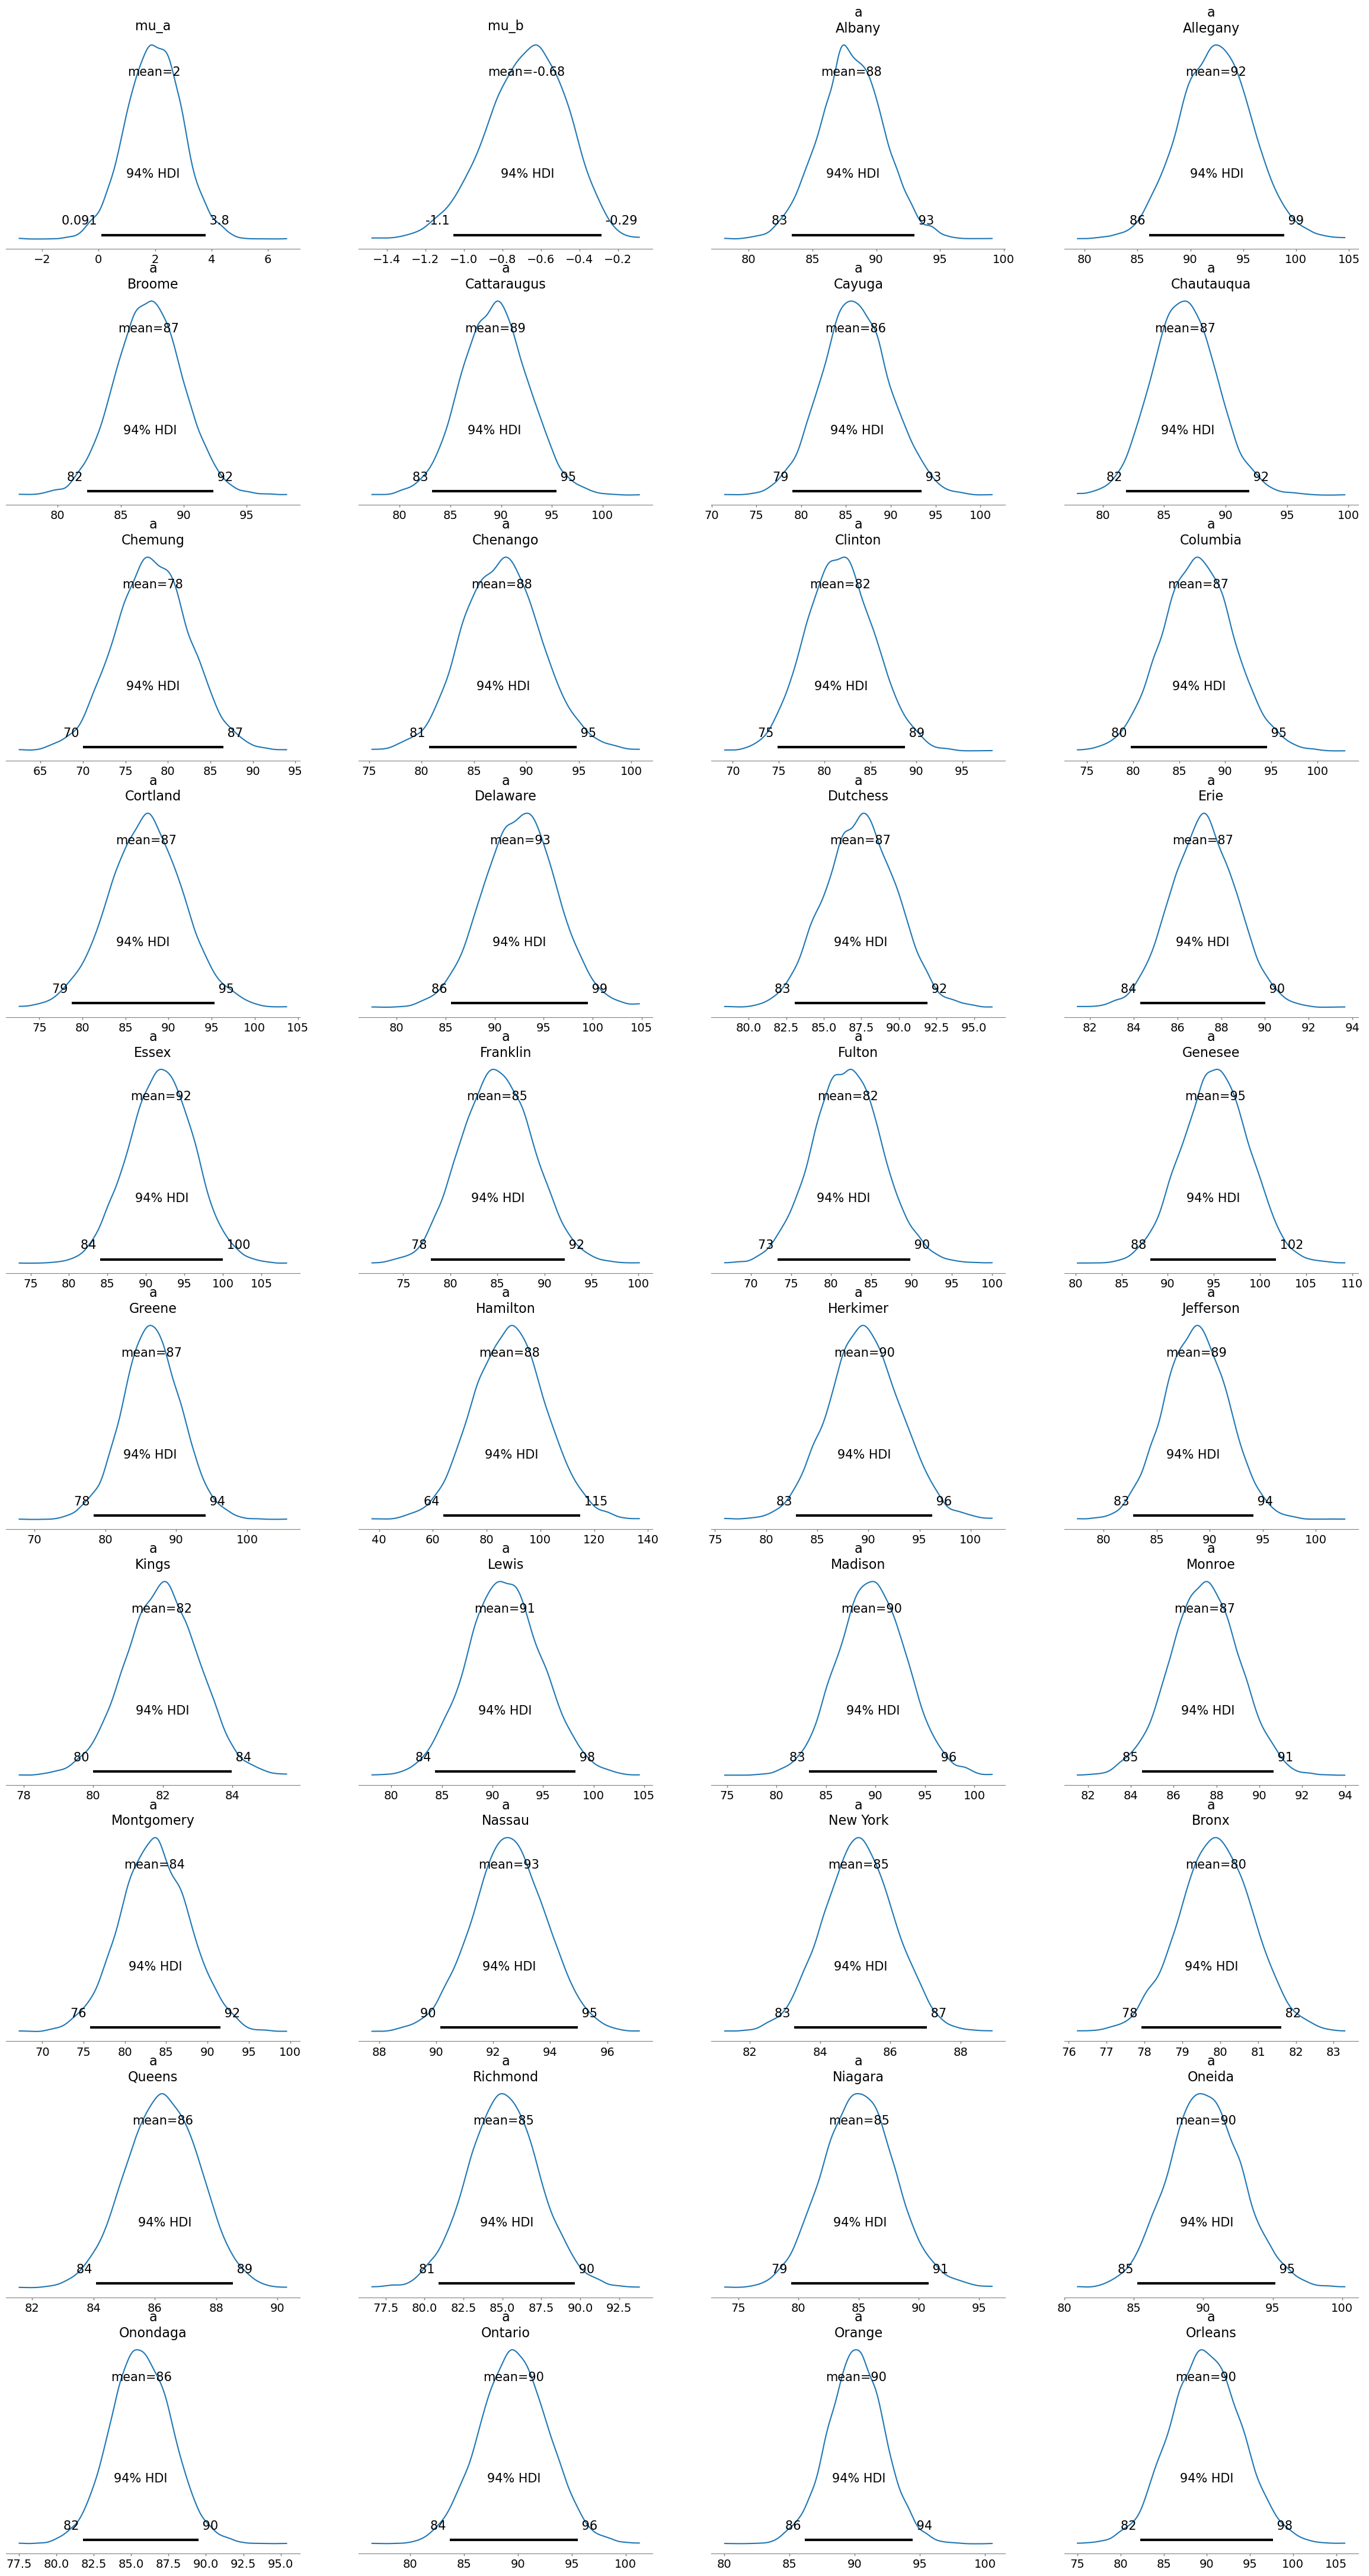

In [135]:
with hierarchical_model:
    az.plot_posterior(hierarchical_trace)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

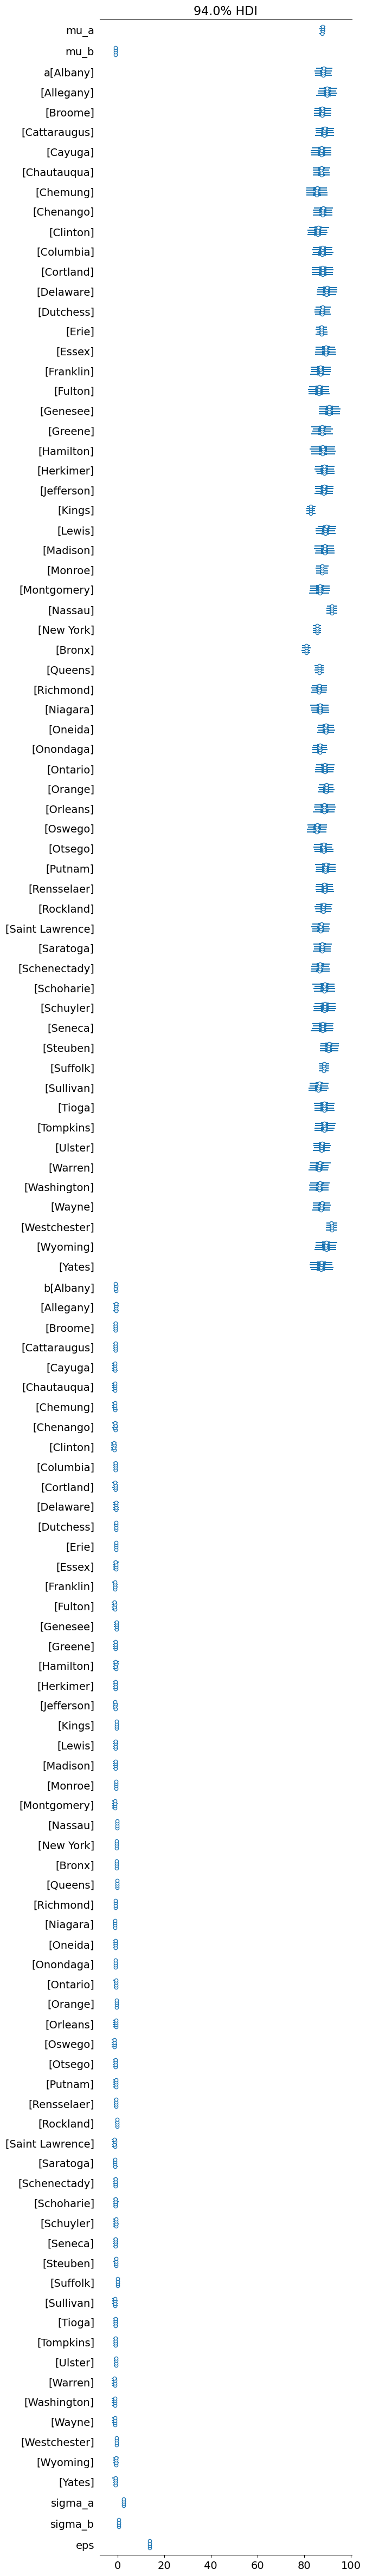

In [122]:
# this plots the high-density-interval but not sure how to interpret 
az.plot_forest(hierarchical_trace)

**Note:** My goal is to be able to understand how `graduation_rate` is affected by the subgroup + county that a particular student belongs to. Using the posterior distribution, be able to predict the graduation rate of a new student belonging to a given subgroup in a county 

# Hierarchical Modeling

[Based on PyData Talk:](https://www.youtube.com/watch?v=pbcxb9xpTBI&t=1274s)

In [72]:
data

,county,grad_rate,subgroup,subgroup_norm
0,Albany,73.7,Hispanic or Latino,0
1,Albany,86.9,White,1
2,Albany,77.4,Multiracial,2
3,Albany,70.4,English Language Learner,3
4,Albany,75.5,Economically Disadvantaged,4
...,...,...,...,...
4675,Wyoming,88.1,Economically Disadvantaged,4
4676,Yates,91.1,White,1
4677,Yates,88.6,Economically Disadvantaged,4
4678,Yates,78.6,White,1


In [77]:
counties_list = data.county.unique()
n_counties = len(counties)
county_dict = dict(zip(counties_list, range(n_counties)))

In [86]:
county_num = data['county_code'] = data.county.replace(county_dict).values
gradrates = data.grad_rate
subgroups = data.subgroup_norm.values # array of len(4680: see map for subgroup meaning)

In [90]:
['Hispanic or Latino', 'White','Multiracial','English Language Learner', 'Economically Disadvantaged', 'Students with Disabilities','Asian or Native Hawaiian/Other Pacific Islander', 'Black or African American', 'American Indian or Alaska Native']

['Hispanic or Latino',
 'White',
 'Multiracial',
 'English Language Learner',
 'Economically Disadvantaged',
 'Students with Disabilities',
 'Asian or Native Hawaiian/Other Pacific Islander',
 'Black or African American',
 'American Indian or Alaska Native']

In [94]:
coords_2 = {'subgroup': ['Hispanic or Latino', 
                         'White','Multiracial','English Language Learner', 'Economically Disadvantaged', 
                         'Students with Disabilities','Asian or Native Hawaiian/Other Pacific Islander', 
                         'Black or African American', 'American Indian or Alaska Native'],'obs_id':np.arange(subgroups.size)}

In [183]:
with pm.Model(coords=coords_2) as pooled_model:
    subgroup_idx = pm.ConstantData("subgroup_idx", subgroups, dims="obs_id")
    a = pm.Normal("a", mu= 85, sigma = 14, dims="subgroup")
    
    theta = a[subgroup_idx]
    sigma = pm.HalfCauchy("sigma", 1)
    
    y = pm.Normal("y", mu = theta, sigma = sigma, observed=data.grad_rate, dims="obs_id")

<Axes: xlabel='grad_rate', ylabel='Proportion'>

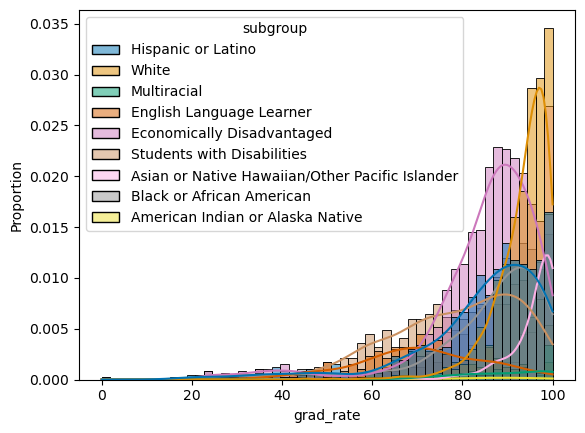

In [149]:
sns.histplot(data, x='grad_rate',hue='subgroup', stat='proportion',kde=True,palette='colorblind')

In [182]:
data.grad_rate.describe()

count    4680.000000
mean       85.097436
std        14.369245
min         0.000000
25%        79.500000
50%        89.100000
75%        95.300000
max       100.000000
Name: grad_rate, dtype: float64

<Axes: >

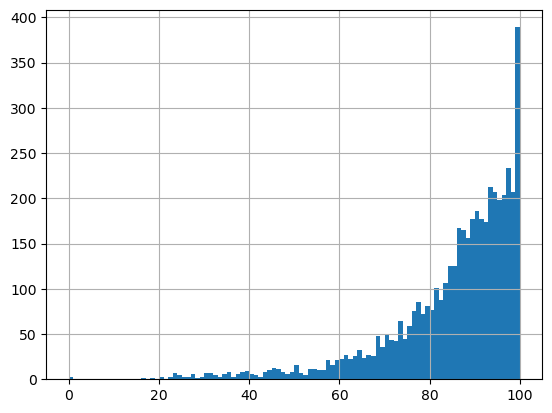

In [181]:
data.grad_rate.hist(bins=100)

In [156]:
with pm.Model(coords=coords_2) as varying_intercept: 
    subgroup_idx = pm.ConstantData("subgroup_idx",subgroups,dims="obs_id")
    county_idx = pm.ConstantData("county_idx", county_num,dims="obs_id")
    
    #hyperpriors
    ic_mu = pm.Normal("ic_mu", mu=2, sigma=1)
    ic_sigma = pm.HalfCauchy("ic_sigma", 1.0)
    
    #varying intercepts 
    county_ic = pm.Normal("county_ic", mu="ic_mu", sigma=ic_sigma, dims="County")

KeyError: "Dimensions {'County'} are unknown to the model and cannot be used to specify a `shape`."

In [154]:
county_num

array([ 0,  0,  0, ..., 60, 60, 60], dtype=int64)

## Testing Stuff

In [148]:
data['log_gradrates'] = log_gradrates = np.log(gradrates + 0.1).values

In [136]:
coords_2

{'subgroup': ['Hispanic or Latino',
  'White',
  'Multiracial',
  'English Language Learner',
  'Economically Disadvantaged',
  'Students with Disabilities',
  'Asian or Native Hawaiian/Other Pacific Islander',
  'Black or African American',
  'American Indian or Alaska Native'],
 'obs_id': array([   0,    1,    2, ..., 4677, 4678, 4679])}

In [18]:
fifteen_counties = data.county.value_counts().head(15).index.tolist()
subgroups = ['White','Hispanic or Latino']

In [23]:
county_df = data[data.county.isin(fifteen_counties)]
county_df = county_df[county_df.subgroup_name.isin(subgroups)]

In [51]:
county_df[['county','subgroup_name','grad_rate']]

,county,subgroup_name,grad_rate
0,Albany,Hispanic or Latino,73.7
1,Albany,White,86.9
11,Albany,Hispanic or Latino,85.9
12,Albany,White,95.5
18,Albany,Hispanic or Latino,88.9
...,...,...,...
4653,Westchester,Hispanic or Latino,88.8
4657,Westchester,Hispanic or Latino,90.3
4658,Westchester,White,96.6
4662,Westchester,White,98.3


In [49]:
county_df.groupby(by=['county','subgroup_name']).grad_rate.mean()

county       subgroup_name     
Albany       Hispanic or Latino    85.880000
             White                 92.200000
Bronx        Hispanic or Latino    80.303676
             White                 91.910000
Dutchess     Hispanic or Latino    84.100000
             White                 91.428571
Erie         Hispanic or Latino    80.070370
             White                 93.683721
Kings        Hispanic or Latino    82.086458
             White                 90.507692
Monroe       Hispanic or Latino    86.450000
             White                 92.015385
Nassau       Hispanic or Latino    91.750943
             White                 98.306000
New York     Hispanic or Latino    83.904800
             White                 97.400000
Onondaga     Hispanic or Latino    79.111111
             White                 91.350000
Orange       Hispanic or Latino    90.476923
             White                 94.260000
Queens       Hispanic or Latino    85.858667
             White     

In [ ]:
county_df.groupby('')

In [14]:
# prereqs 
schools = data.entity_name.unique() 
n_schools = len(schools)
school_lookup = dict(zip(schools, range(n_schools)))

In [17]:
school = data.entity_cd = data.entity_name.replace(school_lookup).values
grad_rate = data.grad_rate

## Pickling Work -> Mapping Dictionaries

In [168]:
nys_cats = pd.read_csv('raw data/GRAD_RATE_AND_OUTCOMES_2022.csv',usecols=
            ['subgroup_name','aggregation_code','aggregation_name','lea_beds','lea_name','nrc_code','nrc_desc','county_name','county_code'],
                       dtype=str)

In [169]:
# removing records that contain aggregated records that aren't useful 
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0000')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0001')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0002')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0003')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0004')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0005')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0006')]
nys_cats = nys_cats[~nys_cats['aggregation_code'].astype('str').str.endswith('0007')]

# renaming columns 
nys_cats = nys_cats.rename(
    columns={'aggregation_code':'beds_cd','aggregation_name':'school','lea_name':'district'})

# normalizing str values 
nys_cats.school = nys_cats.school.str.title()
nys_cats.district = nys_cats.district.str.title()
nys_cats.county_name = nys_cats.county_name.str.title()
nys_cats = nys_cats.reset_index(drop=True)

In [69]:
county_lookup = nys_cats[['county_code','county_name']].drop_duplicates().reset_index(drop=True)
county_lookup = county_lookup.set_index('county_code')
county_lookup = county_lookup.to_dict()

In [143]:
county_lookup =  {'01': 'Albany',
                  '02': 'Allegany',
                  '03': 'Broome',
                  '04': 'Cattaraugus',
                  '05': 'Cayuga',
                  '06': 'Chautauqua',
                  '07': 'Chemung',
                  '08': 'Chenango',
                  '09': 'Clinton',
                  '10': 'Columbia',
                  '11': 'Cortland',
                  '12': 'Delaware',
                  '13': 'Dutchess',
                  '14': 'Erie',
                  '15': 'Essex',
                  '16': 'Franklin',
                  '17': 'Fulton',
                  '18': 'Genesee',
                  '19': 'Greene',
                  '20': 'Hamilton',
                  '21': 'Herkimer',
                  '22': 'Jefferson',
                  '23': 'Kings',
                  '24': 'Lewis',
                  '25': 'Madison',
                  '26': 'Monroe',
                  '27': 'Montgomery',
                  '28': 'Nassau',
                  '31': 'New York',
                  '32': 'Bronx',
                  '33': 'Kings',
                  '34': 'Queens',
                  '35': 'Richmond',
                  '40': 'Niagara',
                  '41': 'Oneida',
                  '42': 'Onondaga',
                  '43': 'Ontario',
                  '44': 'Orange',
                  '45': 'Orleans',
                  '46': 'Oswego',
                  '47': 'Otsego',
                  '48': 'Putnam',
                  '49': 'Rensselaer',
                  '50': 'Rockland',
                  '51': 'Saint Lawrence',
                  '52': 'Saratoga',
                  '53': 'Schenectady',
                  '54': 'Schoharie',
                  '55': 'Schuyler',
                  '56': 'Seneca',
                  '57': 'Steuben',
                  '58': 'Suffolk',
                  '59': 'Sullivan',
                  '60': 'Tioga',
                  '61': 'Tompkins',
                  '62': 'Ulster',
                  '63': 'Warren',
                  '64': 'Washington',
                  '65': 'Wayne',
                  '66': 'Westchester',
                  '67': 'Wyoming',
                  '68': 'Yates'}

In [160]:
#f = open('county_lookup.pkl','wb')
#pickle.dump(county_lookup,f)
#f.close()

In [144]:
data['county_code'] = data.entity_cd.str[:2]
data.county_code = data.county_code.map(county_lookup)
data = data.rename(columns={'county_code':'county'})

In [193]:
counties_gr = data.groupby('county')['grad_rate'].median().sort_values(ascending=True)

<Axes: ylabel='Proportion'>

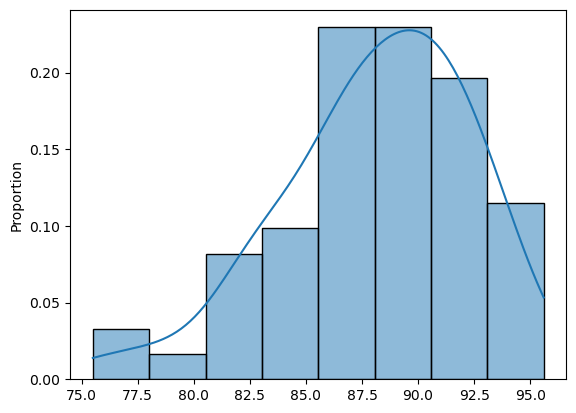

In [195]:
sns.histplot(counties_gr,x=counties_gr.values,stat='proportion',kde=True)

In [207]:
subgroup_list = data.subgroup_name.unique().tolist()
school_list = data.entity_name.unique().tolist()

In [235]:
district_lookup = nys_cats[nys_cats.school.isin(school_list)]
district_lookup

,beds_cd,school,lea_beds,district,nrc_code,nrc_desc,county_code,county_name,subgroup_name
0,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,All Students
1,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,Male
2,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,Female
3,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,General Education Students
4,010100010034,Albany High School,010100010000,Albany City School District,3,Urban-Suburban High Needs,01,Albany,Students with Disabilities
...,...,...,...,...,...,...,...,...,...
82685,662401060010,Walter Panas High School,662401060000,Lakeland Central School District,5,Average Needs,66,Westchester,Non-English Language Learner
82686,662401060010,Walter Panas High School,662401060000,Lakeland Central School District,5,Average Needs,66,Westchester,Not in Foster Care
82687,662401060010,Walter Panas High School,662401060000,Lakeland Central School District,5,Average Needs,66,Westchester,Not Homeless
82688,662401060010,Walter Panas High School,662401060000,Lakeland Central School District,5,Average Needs,66,Westchester,Not Migrant


In [236]:
district_lookup = district_lookup[['school','district']].drop_duplicates().reset_index(drop=True)
district_lookup = district_lookup.set_index('school')
district_lookup = district_lookup.to_dict()

In [243]:
district_lookup = district_lookup['district']

In [245]:
#f = open('district_lookup.pkl','wb')
#pickle.dump(district_lookup,f)
#f.close()

,school,district
0,Albany High School,Albany City School District
130,Green Tech High Charter School,Green Tech High Charter School
226,Albany Leadership Cs-Girls,Albany Leadership Cs-Girls
336,Bethlehem Central Senior High School,Bethlehem Central School District
454,Colonie Central High School,South Colonie Central School District
...,...,...
82134,Yonkers Montessori Academy,Yonkers City School District
82238,Yonkers High School,Yonkers City School District
82354,Riverside High School,Yonkers City School District
82470,Barack Obama School For Social Justice,Yonkers City School District
